# Predict Which Clients will Cancel Subscription to help Account Managers Reduce Churn using Logistic Regression

Our subcription based pricing model means we are exposed to clients cancelling their payments. Therefore, we 
want to be able to predict which clients will cancel their subscription to help Account Managers drive engagement and reduce cancellations. We will use Logistic Regression to predict the account status using different datasets that we collect in the lifetime of the customer.

Please note that the data has been anonymised.

# 1. Import Libaries

Below we are importing all the Python libraries we will need for this project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.gridspec import GridSpec

plt.style.use('fivethirtyeight')
%matplotlib inline
palette = itertools.cycle(sns.color_palette())

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

# 2. Import Data

We will work with three datasets:

a. Adding renewals data

In [2]:
columns = ['customerid','client_status','account_status','customer_name','customer_type','value','year_of_current_deal','cancellation_timing','sector','cancellation_reason']
renewals = pd.read_csv('~/Documents/portfolio/datasets/Renewal-Cancelation Book Anonymised3.csv', names=columns, header=0)
renewals.shape

(1152, 10)

In [3]:
renewals.sample(5)

customerid client_status account_status  customer_name customer_type  \
83          838           Low       Inactive            934         Three   
449         848           Mid         Active            118         Three   
491        1791          High         Active            199           One   
943        2315          high         Active            159           Two   
302        2481          High         Active            616         Three   

     value  year_of_current_deal cancellation_timing       sector  \
83    4950                     2                 NaN       Postal   
449   4000                     3                 NaN  Agriculture   
491   2000                     1                 NaN     Textiles   
943   2950                     1                 NaN  Recruitment   
302   5000                     1                 NaN  Agriculture   

    cancellation_reason  
83   Insufficient Funds  
449                 NaN  
491                 NaN  
943                 NaN  
302                 NaN

Importing the renewal data we have the following variables:

<br>

<b>customerid</b> : 
a unique identifier for each account that will be used to join additional datasets later on 

<b>client_status</b> : 
a grading system of the account given by the account manager that denotes the level of usage and engagement, high means no cause for concern as high engagement and usage and low means little/no usage and engagement, high risk of cancellation.

<b>account_status</b> : 
denotes whether the client is active (paying customer) or inactive (cancelled)

<b>customer_name</b> : 
customer number     

<b>customer_type</b> : 
we categorise into three pots of client according to size in revenue; one being the smallest, and three being the largest.

<b>value</b> : 
the current price of subscription, there are three types of subcription for which the prices differ and this is dependent on the customer type.

<b>year_of_current_deal</b> : 
the year of maturity of the account

<b>cancellation_timing</b> : 
shows if the cancellation was at the start of a period or mid way through

<b>sector</b>: 
the industry that the customer operates in 

<b>cancellation_reason</b> : 
a reason for cancellation picked from a preset list of reasons

b. Adding add-on data

In [4]:
# Importing the dataset

add = pd.read_csv('~/Documents/portfolio/datasets/Uses add-ons.csv') 
add.rename(columns={'Customer ID':'customerid'},inplace=True) # renaming column to merge to dataset
add.shape

(343, 2)

In [5]:
add.head(10)

customerid  Number of times ever used add-on service
0        1589                                      2911
1         169                                       955
2        2946                                        50
3         614                                       554
4        2711                                      2222
5        2279                                       153
6        2173                                       335
7        2111                                       182
8         757                                      3252
9         968                                       100

This data shows us the number of times a customer has used our add-on service. Not all clients use it, and it doesn't receive as good feedback as our main product so this is an important variable to include as customer's disatisfaction with add-ons may cause them to cancel.

c. Adding usage data

In [6]:
# Importing the dataset

usage = pd.read_csv('~/Documents/portfolio/datasets/usage report duration.csv') 
usage.rename(columns={'CustomerId':'customerid'},inplace=True) # renaming column to merge to dataset
usage.shape

(1130, 49)

In [7]:
usage.head()

customerid  year    0   1  2   3   4   5   6   7  ...  37  38  39  40  \
0        1452     1  451 NaN  0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1         160     2    3 NaN  0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
2        1809     1    1 NaN  0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
3         168     1   33 NaN  0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
4        2388     1    9 NaN  0 NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

   Duration  First month usage  Total Logins  Number of Users  \
0         1                451           451               25   
1         1                  3             3                4   
2         1                  1             1                1   
3         1                 33            33                1   
4         1                  9             9                2   

   Number of Active Users  Difference in total users and active  
0                      17                                     8  
1                       1                                     3  
2                       1                                     0  
3                       1                                     0  
4                       1                                     1  

[5 rows x 49 columns]

The usage data shows the number of sessions the customer has had on our platform each month (months numbered 0 to 40), first month usage, number of users, number of active users, and the difference between total users and active. Active meaning the user has logged in and used the platform at least once.

# 3. Exploratory Data Analysis (EDA) - For Data Cleaning

In this section we will look at each dataset in turn and clean them.

a. Cleaning renewals data

In [8]:
renewals.shape

(1152, 10)

In [9]:
# Identifing null values

renewals.isnull().sum()

customerid                 0
client_status             18
account_status             0
customer_name              0
customer_type              0
value                      0
year_of_current_deal       0
cancellation_timing     1097
sector                     0
cancellation_reason      899
dtype: int64

In [10]:
# Dropping any unwanted columns. 

renewals.drop(columns=['cancellation_timing'],
              inplace=True)

In [11]:
# Indentifying the rows of the null values - they are newly won clients waiting for an engagement rating from Account Managers

renewals[renewals['client_status'].isnull()].any(axis=1)

81      True
147     True
169     True
172     True
237     True
241     True
292     True
346     True
348     True
401     True
415     True
428     True
788     True
799     True
932     True
972     True
1012    True
1074    True
dtype: bool

In [12]:
# We can fill these 18 account status' in with 'Unknown'

renewals['client_status'].fillna('Unknown', inplace = True)

In [13]:
# Checking that the previous null values are filled as expected

renewals.loc[44]

customerid                     1284
client_status                   Mid
account_status               Active
customer_name                   833
customer_type                 Three
value                          3000
year_of_current_deal              2
sector                  Electronics
cancellation_reason             NaN
Name: 44, dtype: object

In [14]:
# Exploring the client status shows us that we should merge the two high categories.

renewals['client_status'].value_counts()

Mid        527
High       482
Low         75
high        50
Unknown     18
Name: client_status, dtype: int64

In [15]:
# Cleaning the two high categories

renewals['client_status'] = renewals['client_status'].replace({'high': 'High'})
renewals['client_status'].value_counts()

High       532
Mid        527
Low         75
Unknown     18
Name: client_status, dtype: int64

In [16]:
# Checking how many inactive customers have a missing value in cancellation reason

cancelled = renewals[renewals['account_status'] == 'Inactive']
cancelled[cancelled['cancellation_reason'].isnull()].any(axis=1)

198    True
501    True
727    True
997    True
dtype: bool

In [17]:
# filling in the cancellation reason of the inactive accounts with 'Reason Unknown'.

renewals.loc[((renewals.account_status == 'Inactive') & (renewals.cancellation_reason.isnull())), 
             'cancellation_reason'] ='Reason Unknown'

In [18]:
# checking that the 32 cancelled account's cancellation reasons have been filled in

renewals.isnull().sum()

customerid                0
client_status             0
account_status            0
customer_name             0
customer_type             0
value                     0
year_of_current_deal      0
sector                    0
cancellation_reason     895
dtype: int64

In [19]:
# Checking cancellation reason to see what the options are and if it needs cleaning

renewals['cancellation_reason'].value_counts()

No longer required              132
Switched to competitor           62
Insufficient Funds               34
Data Quality                     12
Low engagement                    5
Reason Unknown                    4
Merged with exsisting client      4
Data quality                      2
We terminated contract            2
Name: cancellation_reason, dtype: int64

In [20]:
# Combining the two data quality buckets 

renewals['cancellation_reason'] = renewals['cancellation_reason'].replace({'Data Quality': 'Data quality'})
renewals['cancellation_reason'].value_counts()

No longer required              132
Switched to competitor           62
Insufficient Funds               34
Data quality                     14
Low engagement                    5
Reason Unknown                    4
Merged with exsisting client      4
We terminated contract            2
Name: cancellation_reason, dtype: int64

In [21]:
# Checking for duplicate entries for clients

renewals.customer_name.value_counts()

569     2
1151    1
386     1
380     1
381     1
       ..
768     1
769     1
770     1
771     1
1       1
Name: customer_name, Length: 1151, dtype: int64

In [22]:
# locating the rows of the duplicate accounts and checking both rows have the same information before deleting one

duplicate_name = renewals.customer_name == 569
renewals[duplicate_name]

customerid client_status account_status  customer_name customer_type  \
641        1490           Mid       Inactive            569           Two   
642        1490           Mid       Inactive            569           Two   

     value  year_of_current_deal        sector     cancellation_reason  
641  10500                     1  Construction  Switched to competitor  
642  10500                     1  Construction  Switched to competitor

In [23]:
# Deleting the one duplicate row where the cancellation reason is unknown

renewals.drop(renewals.index[173], inplace = True)

In [24]:
# Checking there are no more duplications

renewals.customer_name.value_counts()

569     2
1151    1
386     1
380     1
381     1
       ..
762     1
761     1
760     1
759     1
1       1
Name: customer_name, Length: 1150, dtype: int64

In [25]:
# Another check that a row was permanently deleted from dataset

renewals.shape

(1151, 9)

In [26]:
# Inspecting the account status

renewals['account_status'].value_counts()

Active      895
Inactive    256
Name: account_status, dtype: int64

Now the renewals dataset is clean let's merge it with the second dataset.

In [27]:
# Merging datasets on 'customerid' to bring in the extra column 'Number of times ever used distribution' only to 
# those customers in our original renewals dataset that feature in the new dataset

renewals_add = pd.merge(renewals, add, how='left', on=['customerid'])
renewals_add.shape

(1151, 10)

b. Cleaning add-on data

In [28]:
renewals_add.head(10)

customerid client_status account_status  customer_name customer_type  \
0        1642          High         Active            116         Three   
1        2300          High         Active            245         Three   
2        2122          High         Active            301         Three   
3         869           Mid         Active            482         Three   
4        2580           Mid         Active            514         Three   
5         863          High         Active            710         Three   
6        2237          High         Active            873         Three   
7         440          High         Active            884         Three   
8        2593           Mid         Active            939         Three   
9        1956           Mid         Active            998         Three   

   value  year_of_current_deal       sector cancellation_reason  \
0   4950                     1  Electronics                 NaN   
1   3900                     1  Electronics                 NaN   
2   4950                     1  Electronics                 NaN   
3   4750                     3  Electronics                 NaN   
4   2000                     1  Electronics                 NaN   
5   4150                     2  Electronics                 NaN   
6   4950                     1  Electronics                 NaN   
7   4500                     1  Electronics                 NaN   
8   4750                     1  Electronics                 NaN   
9   4950                     1  Electronics                 NaN   

   Number of times ever used add-on service  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4                                       NaN  
5                                       NaN  
6                                     757.0  
7                                       NaN  
8                                       NaN  
9                                       NaN

In [29]:
# Finding how many null values in the new column

renewals_add['Number of times ever used add-on service'].isnull().sum()

892

In [30]:
# From the above numbers we can calculate the number of rows (clients) in the new add-on dataset that were 
# dropped because the 'customerid' didn't appear in the renewals dataset. We do not have any other data for these 
# and so we can leave them out.

346 - (1151-892)

87

In [31]:
# From that we can work out the percentage of our clients that have ever used the add-on service

(346-87)/1151*100

22.502172024326672

In [32]:
# Replacing the null values with 0 for the number of times the client has used distribution

renewals_add['Number of times ever used add-on service'].fillna('0', inplace = True)

In [33]:
# Checking the above step means there are no null values left in the new column

renewals_add['Number of times ever used add-on service'].isnull().sum()

0

In [34]:
# Casting the new distribution column as an integer and looking at the mean, min, max etc for the 23.4% of our 
# dataset that used distribution

renewals_add['Number of times ever used add-on service'] = renewals_add['Number of times ever used add-on service'].astype(float)
filter = renewals_add['Number of times ever used add-on service'] != 0
renewals_add[filter].describe()

customerid  customer_name         value  year_of_current_deal  \
count   259.000000     259.000000    259.000000            259.000000   
mean   1378.814672     578.034749   4304.247104              1.776062   
std     676.392858     333.978279   1355.001413              0.982426   
min      35.000000       1.000000   1236.000000              1.000000   
25%     856.500000     286.500000   4000.000000              1.000000   
50%    1385.000000     562.000000   4650.000000              2.000000   
75%    1910.000000     874.000000   4950.000000              2.000000   
max    2665.000000    1145.000000  15000.000000              5.000000   

       Number of times ever used add-on service  
count                                259.000000  
mean                                 390.544402  
std                                 1337.477804  
min                                    3.000000  
25%                                   13.000000  
50%                                   81.000000  
75%                                  338.000000  
max                                19835.000000

From the above we can see that 75% of the data points are between 1 and 338, however we have a large outlier (19,835) that is pulling the mean of 390.6 upwards.

c. Cleaning usage data

In [35]:
usage.columns # columns in the third dataset

Index(['customerid', 'year', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', 'Duration',
       'First month usage', 'Total Logins', 'Number of Users',
       'Number of Active Users', 'Difference in total users and active'],
      dtype='object')

In [36]:
usage.dtypes

customerid                                int64
year                                      int64
0                                         int64
1                                       float64
2                                         int64
3                                       float64
4                                       float64
5                                       float64
6                                       float64
7                                       float64
8                                       float64
9                                       float64
10                                      float64
11                                      float64
12                                      float64
13                                      float64
14                                      float64
15                                      float64
16                                      float64
17                                      float64
18                                      

In [37]:
# Filling in the NaNs for the duration columns

usage.loc[:,'0':'40'] = usage.loc[:,'0':'40'].fillna(0)

In [38]:
# Create a new column in the dataframe to show the % of active users for each customer

usage['% of active users'] = usage['Number of Active Users']/usage['Number of Users']*100

In [39]:
usage['% of active users'].describe()

count    1130.000000
mean       86.899980
std        16.605422
min        10.000000
25%        77.777778
50%        93.750000
75%       100.000000
max       100.000000
Name: % of active users, dtype: float64

The average percentage of active users for a customer is 86.9%, a reasonably high percentage. However, the lowest percentage of active users is 10%, which shows little engagement. Visualising the data using the boxplot below helps us to see that 10% is somewhat an outlier as represented in the stand alone point at the bottom of the range below. The boxplot also shows us that the majority of the customers sit in the interquartile range of percentage of active users between 77.8% and 100%.

Text(0.5, 1.0, 'Distribution of % of Active Users')

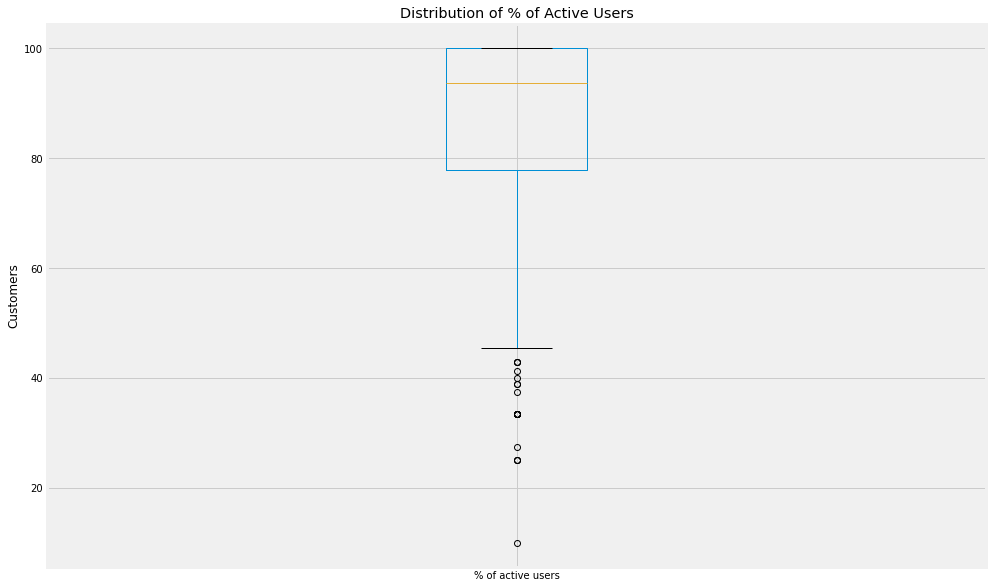

In [40]:
# Visualising the distribution of % of active users to understand the data better

usage.boxplot(column='% of active users', figsize=(15,10))

plt.ylabel('Customers');
plt.title('Distribution of % of Active Users')

In [41]:
# Merging the two datasets on 'customerid', which is unique to every customer, dropping any customers in the usage 
# dataset for which we don't have renewal data for.

renewals_add_usage = pd.merge(renewals_add, usage, on=['customerid'])
renewals_add_usage.shape

(1133, 59)

Now we have taken our original renewals dataset and merged onto it the add-on and customer usage data we have the following new dataset to build a model with: 

In [42]:
renewals_add_usage.head()

customerid client_status account_status  customer_name customer_type  \
0        1642          High         Active            116         Three   
1        2300          High         Active            245         Three   
2        2122          High         Active            301         Three   
3         869           Mid         Active            482         Three   
4        2580           Mid         Active            514         Three   

   value  year_of_current_deal       sector cancellation_reason  \
0   4950                     1  Electronics                 NaN   
1   3900                     1  Electronics                 NaN   
2   4950                     1  Electronics                 NaN   
3   4750                     3  Electronics                 NaN   
4   2000                     1  Electronics                 NaN   

   Number of times ever used add-on service  ...   38   39   40  Duration  \
0                                       0.0  ...  0.0  0.0  0.0        17   
1                                       0.0  ...  0.0  0.0  0.0         7   
2                                       0.0  ...  0.0  0.0  0.0         9   
3                                       0.0  ...  0.0  0.0  0.0        29   
4                                       0.0  ...  0.0  0.0  0.0         3   

   First month usage  Total Logins  Number of Users  Number of Active Users  \
0                 14          1339               22                      17   
1                 27           291                7                       6   
2                  8           296                3                       3   
3                  7           675                9                       8   
4                  2            11                1                       1   

   Difference in total users and active  % of active users  
0                                     5          77.272727  
1                                     1          85.714286  
2                                     0         100.000000  
3                                     1          88.888889  
4                                     0         100.000000  

[5 rows x 59 columns]

In [43]:
renewals_add_usage['account_status'].value_counts()

Active      889
Inactive    244
Name: account_status, dtype: int64

# 3. EDA - Exploring relationships between variables

Let's explore the relationships between the variables.

In [44]:
import seaborn as sns
sns.pairplot(renewals_add_usage)

The above visual plots of the coefficients isn't too helpful, let's look at the correlation coefficients using the two plots below: 

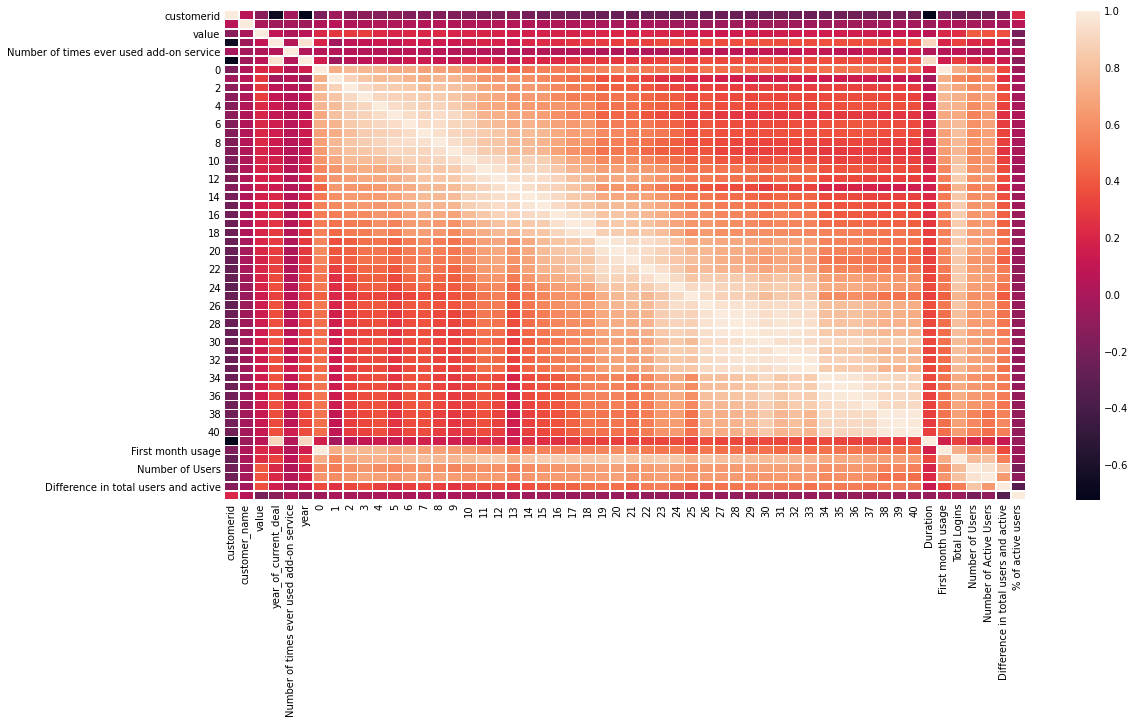

In [52]:
plt.figure(figsize=(16,9))
sns.heatmap(renewals_add_usage.corr(), linewidths=.5 )

In [44]:
renewals_add_usage.corr()

customerid  customer_name     value  \
customerid                                  1.000000       0.061480 -0.125782   
customer_name                               0.061480       1.000000  0.004052   
value                                      -0.125782       0.004052  1.000000   
year_of_current_deal                       -0.659724      -0.046657  0.084586   
Number of times ever used add-on service   -0.030441      -0.028144  0.018312   
year                                       -0.724385      -0.047196  0.061887   
0                                          -0.178433       0.023323  0.210172   
1                                          -0.043219       0.058589  0.290255   
2                                          -0.115370       0.029054  0.289969   
3                                          -0.121128       0.024966  0.299409   
4                                          -0.142415       0.031559  0.221617   
5                                          -0.119420       0.029317  0.199540   
6                                          -0.151745       0.018859  0.214305   
7                                          -0.145865       0.032555  0.213503   
8                                          -0.158307       0.037891  0.224781   
9                                          -0.158514       0.022074  0.206812   
10                                         -0.174497       0.025837  0.205092   
11                                         -0.181418       0.034728  0.198183   
12                                         -0.185024       0.034064  0.189031   
13                                         -0.148505       0.045557  0.161941   
14                                         -0.205946       0.033807  0.173326   
15                                         -0.224245       0.022666  0.185384   
16                                         -0.221482       0.026570  0.177326   
17                                         -0.238019       0.026530  0.184503   
18                                         -0.250101       0.018334  0.196681   
19                                         -0.254146      -0.005725  0.206701   
20                                         -0.261196      -0.012152  0.207738   
21                                         -0.269462      -0.008102  0.186531   
22                                         -0.269521      -0.006627  0.200920   
23                                         -0.270087      -0.021073  0.195019   
24                                         -0.287178      -0.041958  0.195096   
25                                         -0.253847      -0.058428  0.142817   
26                                         -0.279709      -0.056052  0.151748   
27                                         -0.251932      -0.041990  0.139365   
28                                         -0.257368      -0.044424  0.144803   
29                                         -0.253789      -0.046917  0.148040   
30                                         -0.259870      -0.045115  0.157248   
31                                         -0.246187      -0.045481  0.146379   
32                                         -0.252177      -0.046688  0.148856   
33                                         -0.250153      -0.048239  0.149603   
34                                         -0.247990      -0.037824  0.148946   
35                                         -0.240178      -0.032271  0.149480   
36                                         -0.232794      -0.039616  0.150534   
37                                         -0.234301      -0.040954  0.145489   
38                                         -0.224454      -0.023491  0.118849   
39                                         -0.214807      -0.024563  0.122685   
40                                         -0.228817      -0.025485  0.117420   
Duration                                   -0.724800      -0.055796  0.059812   
First month usage                          -0.178433       0.023323  0.21

The above table and heatmap help us see which varibales are correlated. Duration as we would expect is highly correlated with the other year variables. The overall correlation between the monthly usage (0 - 40) variables is more easily intepreted by the heatmap. We can see that as time goes on the correlation gets stronger. However, the strongest correlation on the usage month is 0.36 at 26. This isn't considerably high.

The number of times ever used add-on service, total logins, number of users, number of active users, difference in total users and active and % of active users do not offer any higher correlation with duration either. The highest correlation being 0.32 between the total logins and duration. 

The variables I expected higher correlation with was % of active users, number of active users or difference in total users and active. This is because these variables give us an indicating of engagement on a licences basis. For example, a usage month could indicate great usage but if it's just one user out of 10 paid licences, we could be at risk of losing a client when the company realises they aren't utilising the full 10 licences. However, if 8 out of 10 licences are engaging every month we may be less concern with that client.

# 4. Logistic Regression

Here we will fit a logistic regression model. Due to the nature of the data we are using 'first month usage' and '% of active users' for example we will need to build up this information over the lifetime of a customer. Therefore, the model will be used once a customer has had their subscription for a month or longer.

First we will define the target, which is the account status and then we will define the featurs which are the predictors.

In [45]:
logreg = LogisticRegression()

# Setting up the features
cont_cols = ['Number of Active Users','24','26','25','28','30','32','33']

X = renewals_add_usage[cont_cols]
    
# Setting up the target

renewals_add_usage['account_status_map'] = renewals_add_usage.account_status.map({'Inactive':0, 'Active':1})

y = renewals_add_usage.account_status_map

In [46]:
X

Number of Active Users    24    26    25    28   30   32   33
0                         17   0.0   0.0   0.0   0.0  0.0  0.0  0.0
1                          6   0.0   0.0   0.0   0.0  0.0  0.0  0.0
2                          3   0.0   0.0   0.0   0.0  0.0  0.0  0.0
3                          8  13.0  21.0  13.0  86.0  0.0  0.0  0.0
4                          1   0.0   0.0   0.0   0.0  0.0  0.0  0.0
...                      ...   ...   ...   ...   ...  ...  ...  ...
1128                      26   0.0   0.0   0.0   0.0  0.0  0.0  0.0
1129                       1   0.0   0.0   5.0   2.0  1.0  4.0  0.0
1130                       2   0.0   0.0   0.0   0.0  0.0  0.0  0.0
1131                       8  32.0  15.0  37.0  29.0  0.0  0.0  0.0
1132                      10   0.0   0.0   0.0   0.0  0.0  0.0  0.0

[1133 rows x 8 columns]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88)

In [48]:
# Standardise the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
# Fit a logistic regression model and store the class predictions.

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

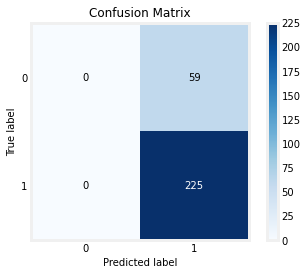

In [50]:
skplt.metrics.plot_confusion_matrix(y_test, pred)

Here the confusion matrix highlights in row 0; 0 is a true positive - 0 were predicted as cancelled and that was correct. It shows us the model generated 59 false positives, therefore it predicted the customers to be live, however they cancelled. In row 1; 0 were false negative and 225 were true positives - predicted as live and are indeed live. This matrix highlights to us that even though the accuracy score is the highest achieved so far, the model still gives a considerable number of false positives. In an application like this we would rather false negatives, whereby the model predicts a customer will cancel, resulting in account managers encouraging engagement and checking in more regularly when in fact they weren't going to cancel as oppose to account managers taking a step back from customers who are likely to cancel. 

In [51]:
# accuracy score for this model

score_logregression = logreg.score(X_test, y_test)
score_logregression

0.7922535211267606

The accuracy score for this model is 82.3%.

In [52]:
# Calculating the accuracy of a probability forecast where the best possible brier score is 0 for complete accuracy.

metrics.brier_score_loss(y_test, pred)

0.20774647887323944

Our dataset has an imbalance in that there are 889 active and 243 inactive customers. Let's play around with downsizing the dataset size to control for the imbalance and see how it effects the model.

In [53]:
# Separate majority and minority classes
renewals_add_usage_majority = renewals_add_usage[renewals_add_usage.account_status_map==1]
renewals_add_usage_minority = renewals_add_usage[renewals_add_usage.account_status_map==0]
 
# Downsample majority class
renewals_add_usage_majority_downsampled = renewals_add_usage_majority.sample( 
                                 n=243,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
renewals_add_usage_downsampled = pd.concat([renewals_add_usage_majority_downsampled, renewals_add_usage_minority])
 
# Display new class counts
renewals_add_usage_downsampled.shape

(487, 60)

In [54]:
logreg = LogisticRegression()

# Setting up the features

cont_cols = ['First month usage','Number of Users','Number of Active Users','Total Logins']

X = renewals_add_usage_downsampled[cont_cols]
    
# Setting up the target

y = renewals_add_usage_downsampled.account_status_map

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88)

In [56]:
# Standardise the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
# Fit a logistic regression model and store the class predictions.

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

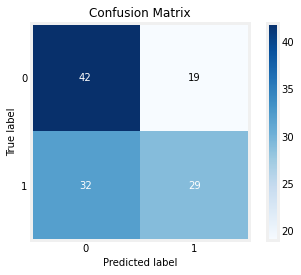

In [58]:
skplt.metrics.plot_confusion_matrix(y_test, pred)

Here the confusion matrix highlights in row 0; 0 is a true positive - 42 were predicted as cancelled and that was correct. It shows us the model generated 19 false positives, therefore it predicted the customers to be live, however they cancelled. This is a much better position than the confusion matrix of the first model. 

In row 1; 32 were false negative and 29 were true positives - predicted as live and are indeed live. This matrix highlights to us less false positives and more false negatives than the last one. As mentioned previously, we would rather false negatives, whereby the model predicts a customer will cancel, when in fact they weren't going to cancel as oppose to us not being aware of customers who are likely to cancel. 

In [59]:
# Accuracy score

score_logregression = logreg.score(X_test, y_test)
score_logregression

0.5819672131147541

In [60]:
# Brier score indicator

metrics.brier_score_loss(y_test, pred)

0.4180327868852459

The accuracy scores here are not as high as the previous sample that didn't control for the imbalance of the target. However, I don't think this means the model is worse and predicting the account status. The confusion matrix for the second model is more positive.

# 6. Evaluation of Logistic Regression

Here we added usage statistics available to us once a customer begins to take advantage of their subscription. The first model has the highest accuracy score which may mean the model additional predictive power. However, there are low correlations and a high number of false positives. A limitation is that around 77% of the entire dataset represents live customers. Training the models highlights a tendency for them to predict the customer will be live as default because of the ratio of live to cancelled customers. Therefore, we must be cautious that the high accuracy scores are a result of the live default predictions as oppose to the model being able to effective map a relationship between the variables used and the account status. This lead us to control for the imbalance in account status which generated a much more positive confusion matrix, despite the lower accuracy score. 

There is a lot more to explore here, next steps are to explore different parameters, look at different ways to evaulate the regression models in terms of accuracy and fit, and also look at the documentation and work around rare events correction, a practice that looks to deal with logistic regression's potential to sharply underestimate the probability of rare events. 